In [1]:
import condo
import numpy as np
import matplotlib.pyplot as plt
import ot
import pandas as pd
import seaborn as sns
import sklearn
import time
import warnings

from matplotlib.colors import LogNorm

In [2]:
N_T = 100
N_S = 100

# How confounder X affects the distribution of T and S
mu_hotdog = 5.
sigma_hotdog = 1.0
mu_not = 0.0
sigma_not = 2.0

# How batch effect affects S
batch_m = 2
batch_b = 5
# The true batch correction from Sbatch to S
true_m = 1. / batch_m
true_b = -1 * batch_b / batch_m

In [3]:
n_hotdogT = 75 
n_notT = 25
n_hotdogS = 25
n_notS = 75
X_T = np.array([['hotdog']*n_hotdogT + ['not']*n_notT]).reshape((N_T, 1))
X_S = np.array([['hotdog']*n_hotdogS + ['not']*n_notS]).reshape((N_S, 1))

In [4]:
Strue = np.nan * np.ones((N_S, 1))
T = np.nan * np.ones((N_T, 1))
Strue[np.where(X_S[:,0] == 'hotdog'), 0] = np.random.normal(
    mu_hotdog, sigma_hotdog, size=(n_hotdogS))
T[np.where(X_T[:,0] == 'hotdog'), 0] = np.random.normal(
    mu_hotdog, sigma_hotdog, size=(n_hotdogT))
Strue[np.where(X_S[:,0] == 'not'), 0] = np.random.normal(
    mu_not, sigma_not, size=(n_notS))
T[np.where(X_T[:,0] == 'not'), 0] = np.random.normal(
    mu_not, sigma_not, size=(n_notT))

Sbatch = batch_m * Strue + batch_b

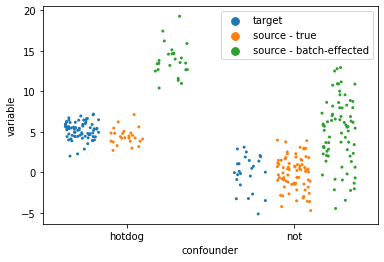

In [5]:
dfT = pd.concat([
    pd.DataFrame(T, columns=['variable']), pd.DataFrame(X_T, columns=['confounder'])
], axis=1)
dfT["batch"] = "target"
dfStrue = pd.concat([
    pd.DataFrame(Strue, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
], axis=1)
dfStrue["batch"] = "source - true"
dfSbatch = pd.concat([
    pd.DataFrame(Sbatch, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
], axis=1)
dfSbatch["batch"] = "source - batch-effected"

df = pd.concat([dfT, dfStrue, dfSbatch], axis=0)
sns.stripplot(
    x="confounder",
    y="variable",
    hue="batch",
    jitter=0.3,
    dodge=True,
    s=3,
    data=df)
plt.legend(loc='best', title='');

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="location-scale",
        divergence="mmd",
        model_type="empirical",
        optim_kwargs={"epochs": 100, "alpha": 1e-4, "beta": 0.9},
        debug=True,
        verbose=1
    )
    cder.fit(Sbatch, T, X_S, X_T)
    Sadapted = cder.transform(Sbatch)
    
lter = ot.da.LinearTransport()
lter.fit(Xs=Sbatch, Xt=T)
Slinear = lter.transform(Xs=Sbatch)

epoch:0 -41.82875->-60.58695 avg:-51.30772
epoch:1 -55.17520->-58.94426 avg:-59.69226
epoch:2 -65.18380->-69.07574 avg:-62.22007
epoch:3 -58.62490->-60.89567 avg:-60.68054
epoch:4 -61.35349->-70.57079 avg:-59.99160
epoch:5 -57.45583->-73.06765 avg:-63.82554
epoch:6 -66.32846->-55.89143 avg:-63.42196
epoch:7 -54.87318->-72.30623 avg:-63.36374
epoch:8 -53.72445->-65.92531 avg:-63.16839
epoch:9 -66.73915->-63.22775 avg:-64.35011
epoch:10 -65.40857->-59.94653 avg:-64.54066
epoch:11 -64.53635->-58.03368 avg:-64.90793
epoch:12 -54.55639->-60.46835 avg:-64.45439
epoch:13 -65.97206->-65.84683 avg:-65.18589
epoch:14 -68.96268->-69.87151 avg:-66.07820
epoch:15 -64.67596->-60.75637 avg:-63.89197
epoch:16 -61.17378->-68.56278 avg:-65.51480
epoch:17 -75.58085->-71.72054 avg:-66.61394
epoch:18 -68.13584->-65.89953 avg:-64.63485
epoch:19 -57.41548->-56.38360 avg:-66.09818
epoch:20 -67.09085->-64.66723 avg:-66.81956
epoch:21 -68.79477->-67.30653 avg:-66.03139
epoch:22 -67.93452->-57.50262 avg:-67.3013

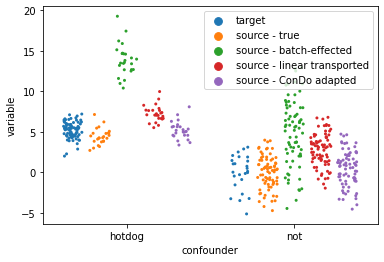

In [7]:
dfSadapted = pd.concat([
    pd.DataFrame(Sadapted, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
], axis=1)
dfSadapted["batch"] = "source - ConDo adapted"

dfSlinear = pd.concat([
    pd.DataFrame(Slinear, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
], axis=1)
dfSlinear["batch"] = "source - linear transported"

df = pd.concat([dfT, dfStrue, dfSbatch, dfSlinear, dfSadapted], axis=0)
sns.stripplot(
    x="confounder",
    y="variable",
    hue="batch",
    jitter=0.3,
    dodge=True,
    s=3,
    data=df)
plt.legend(loc='best', title='');

In [8]:
print(batch_m, batch_b)
print(true_m, true_b)
print(cder.M_, cder.b_)
print((lter.A_, lter.B_))

2 5
0.5 -2.5
[[0.53229163]] [-2.17417233]
(array([[0.50250097]]), array([[0.28345933]]))


In [9]:
print(np.sqrt(np.mean((Strue - Slinear) ** 2)))
print(np.sqrt(np.mean((Strue - Sadapted) ** 2)))

2.801442272610316
0.5831317833650742


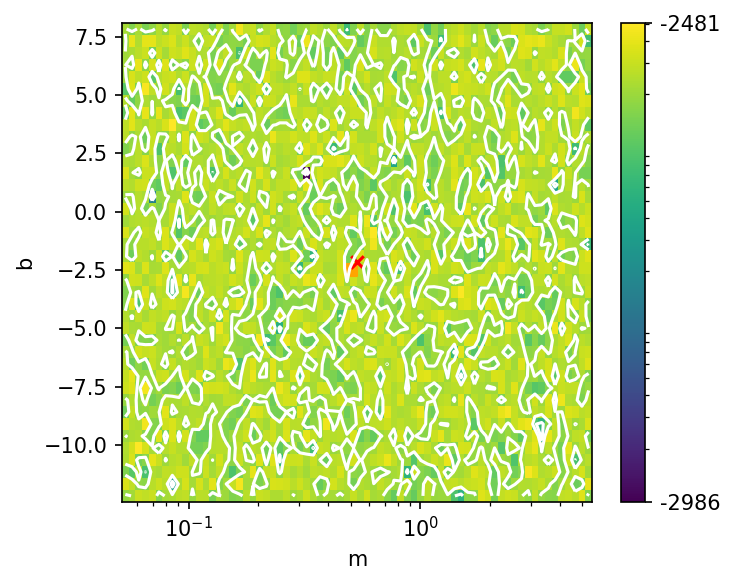

In [16]:
plt.figure(figsize=(5,4), dpi=150)
color_vals = cder.mb_objs_ + 1 - np.min(cder.mb_objs_)
plt.pcolormesh(
    cder.m_plot_, cder.b_plot_, color_vals.T,
    norm=LogNorm(vmin=color_vals.min(), vmax=color_vals.max())
);
plt.xscale('log');

cbar = plt.colorbar();
cbar.ax.get_yaxis().set_ticks([color_vals.min(), color_vals.max()]);
cbar.ax.get_yaxis().set_ticklabels(
    [int(np.round(cder.mb_objs_.min())), int(np.round(cder.mb_objs_.max()))]);
cont = plt.contour(
    cder.m_plot_, cder.b_plot_, color_vals.T, 
    levels=np.geomspace(color_vals.min(), color_vals.max(), 8), colors='white', linestyles='solid');
plt.ylabel('b');
plt.xlabel('m');
plt.scatter(true_m, true_b, marker='s', c='orange');
plt.scatter(cder.M_[0,0], cder.b_[0], marker='x', c='red');
plt.tight_layout();